In [1]:
import json
import pandas as pd

BATCH_PATH = 'batches/Batch_4386904_batch_results_1.csv'
MINIMUM_TIME_PER_INSTANCE = 4
CATEGORY_DICTIONARY = {'Adoring': 'Affection', 'Affectionate': 'Affection', 'Caring': 'Affection', 'Cuddly': 'Affection', 'Infatuated': 'Affection', 'Loving': 'Affection', 'Needy': 'Affection', 'Passionate': 'Affection', 'Supportive': 'Affection', 'Angry': 'Anger', 'Annoyed': 'Anger', 'Bitter': 'Anger', 'Disgusted': 'Anger', 'Done': 'Anger', 'Frustrated': 'Anger', 'Furious': 'Anger', 'Irritated': 'Anger', 'Jealous': 'Anger', 'Adventurous': 'Creativity', 'Artistic': 'Creativity', 'Creative': 'Creativity', 'Dreamy': 'Creativity', 'Imaginative': 'Creativity', 'Inspired': 'Creativity', 'Musical': 'Creativity', 'Poetic': 'Creativity', 'Spacey': 'Creativity', 'Thoughtful': 'Creativity', 'Afraid': 'Fear', 'Anxious': 'Fear', 'Awkward': 'Fear', 'Impatient': 'Fear', 'Insecure': 'Fear', 'Nervous': 'Fear', 'Overwhelmed': 'Fear', 'Shy': 'Fear', 'Stressed': 'Fear', 'Uncomfortable': 'Fear', 'Worried': 'Fear', 'Bored': 'Feelings', 'Guilty': 'Feelings', 'Hungry': 'Feelings', 'Hurt': 'Feelings', 'Lazy': 'Feelings', 'Meh': 'Feelings', 'Nostalgic': 'Feelings', 'Sick': 'Feelings', 'Sleepy': 'Feelings', 'Tired': 'Feelings', 'Upset': 'Feelings', 'Amused': 'Happiness', 'Calm': 'Happiness', 'Chill': 'Happiness', 'Content': 'Happiness', 'Excited': 'Happiness', 'Happy': 'Happiness', 'Proud': 'Happiness', 'Relaxed': 'Happiness', 'Relieved': 'Happiness', 'Confident': 'Positivity', 'Determined': 'Positivity', 'Hopeful': 'Positivity', 'Hyped': 'Positivity', 'Motivated': 'Positivity', 'Optimistic': 'Positivity', 'Safe': 'Positivity', 'Strong': 'Positivity', 'Thankful': 'Positivity', 'Ashamed': 'Sadness', 'Disappointed': 'Sadness', 'Empty': 'Sadness', 'Exhausted': 'Sadness', 'Heartbroken': 'Sadness', 'Lonely': 'Sadness', 'Lost': 'Sadness', 'Miserable': 'Sadness', 'Numb': 'Sadness', 'Sad': 'Sadness', 'Sorry': 'Sadness', 'Amazed': 'Surprise', 'Astonished': 'Surprise', 'Conflicted': 'Surprise', 'Confused': 'Surprise', 'Curious': 'Surprise', 'Embarrassed': 'Surprise', 'Interested': 'Surprise', 'Shocked': 'Surprise', 'Surprised': 'Surprise'}

MINIMUM_EMOTION_QUALITY = 0.1
MINIMUM_CATEGORY_QUALITY = 0.2
AUTO_APPROVAL_FRACTION = 0.75

MONEY_PER_INSTANCE = 0.32

batch_df = pd.read_csv(BATCH_PATH)
batch_df['Answer.currentAnnotation'].fillna('', inplace=True)

In [2]:
def should_reject(row, 
                  min_time_per_instance=MINIMUM_TIME_PER_INSTANCE,
                  minimum_emotion_quality=MINIMUM_EMOTION_QUALITY,
                  minimum_category_quality=MINIMUM_CATEGORY_QUALITY,
                  category_dict=CATEGORY_DICTIONARY):
    rejection_reasons = []
    
    # Prepare the annotations and instances
    annotations = row['Answer.currentAnnotation'].strip().split(',')
    instances = json.loads(row['Input.INSTANCE_DATA'])
    
    # Get emotions and categories
    emotions = [instance['emotion'] for instance in instances]
    annotation_categories = [category_dict.get(annotation, 'Invalid') for annotation in annotations]
    categories = [category_dict[emotion] for emotion in emotions]
    
    # Compute emotion and category scores
    correct_emotions = sum(original == annotation for (original, annotation) in zip(emotions, annotations))
    correct_categories = sum(original == annotation for (original, annotation) in zip(categories, annotation_categories))
    emotion_score = correct_emotions / len(emotions)
    category_score = correct_categories / len(categories)
    
    # Include emotion and category score in the row
    row['EmotionScore'] = emotion_score
    row['CategoryScore'] = category_score
    
    # Rule 1: all instances must be annotated
    if len(annotations) < len(instances):
        reason_not_enough = f'Not all instances were annotated. The HIT included {len(instances)} instances but only {len(annotations)} annotations were submited.'
        rejection_reasons.append(reason_not_enough)
    
    # Rule 2: exactly one annotation per instance.
    if len(annotations) > len(instances):
        reason_too_many = f'You annotated more instances that there are in the HIT. The HIT included {len(instances)} instances but {len(annotations)} annotations were annotated. If you are using browser extensions, please verify that they work appropriately with our task.'
        rejection_reasons.append(reason_too_many)
        
    # Rule 3: exactly one annotation per instance.
    if 'Invalid' in annotations:
        reason_invalid = f'Your annotations included an invalid submission. If you are using tools to assist you in your annotation, verify that they do not submit the form before it is populated.'
        rejection_reasons.append(reason_invalid)
        
    # Rule 4: at least N seconds per instance.
    if row.WorkTimeInSeconds <= len(instances) * min_time_per_instance:
        time_per_instance = round(row.WorkTimeInSeconds / len(instances), 1)
        reason_too_fast = f'Your annotation speed is suspicious. The HIT included {len(instances)} instances which involved careful reading, but you took {time_per_instance}s on average for both reading, labelling and reading the feedback notification (which lasts 3.8s unless you close it).'
        rejection_reasons.append(reason_too_fast)
        
    # Rule 5: at least E correct emotion prediction(s).
    sufficiently_good_emotion = emotion_score >= minimum_emotion_quality

    # Rule 6: at least C correct category prediction(s).
    if category_score < minimum_category_quality and (not sufficiently_good_emotion or minimum_emotion_quality == 0.0):
        reason_low_category_quality = f'Your annotation quality is not sufficient. Your emotion score was {correct_emotions}  / {len(emotions)} and your category score was {correct_categories} / {len(categories)}, which are within the bottom bracket of workers for this HIT. Please ensure that you have read the instructions and carefully paid attention to the text.'
        rejection_reasons.append(reason_low_category_quality)
    return (rejection_reasons, emotion_score, category_score)

In [3]:
def prepare_batch(batch, emo_quality, cat_quality):
    batch['Reasons'] = [should_reject(row,
                                      minimum_emotion_quality=emo_quality,
                                      minimum_category_quality=cat_quality)
                          for i, row in batch.iterrows()]
    batch['Reject'] = ['\n'.join(reasons) for (reasons, _, _) in batch.Reasons.tolist()]
    batch['Approve'] = ['x' if reasons == '' else '' for reasons in batch.Reject.tolist()]
    return batch
    
for min_cat_quality in [0.0, 0.1, 0.2, 0.3]:
    batch_cat_df = prepare_batch(batch_df, MINIMUM_EMOTION_QUALITY, min_cat_quality)
    num_approved = sum(batch_cat_df.Approve == 'x')
    pct_approved = round(100 * num_approved / len(batch_cat_df), 2)
    print(f'Using rules and a minimum {min_cat_quality} category threshold approve {pct_approved}% of the annotations ({num_approved} instances total).')

# Compute the median and average scores
batch_cat_df['EmotionScore'] = [emo for (_, emo, _) in batch_cat_df.Reasons.tolist()]
batch_cat_df['CategoryScore'] = [cat for (_, _, cat) in batch_cat_df.Reasons.tolist()]
print(f'The median emotion score is {batch_cat_df.EmotionScore.median()} and the median category score is {batch_df.CategoryScore.median()}.')
print(f'The average emotion score is {batch_cat_df.EmotionScore.mean()} and the average category score is {batch_df.CategoryScore.mean()}.')
print(f'The max emotion score is {batch_cat_df.EmotionScore.max()} and the max category score is {batch_df.CategoryScore.max()}.')


Using rules and a minimum 0.0 category threshold approve 99.33% of the annotations (1342 instances total).
Using rules and a minimum 0.1 category threshold approve 97.63% of the annotations (1319 instances total).
Using rules and a minimum 0.2 category threshold approve 92.6% of the annotations (1251 instances total).
Using rules and a minimum 0.3 category threshold approve 83.2% of the annotations (1124 instances total).
The median emotion score is 0.1 and the median category score is 0.3.
The average emotion score is 0.11428571428571427 and the average category score is 0.34263508512213176.
The max emotion score is 0.9 and the max category score is 1.0.


In [4]:
batch_df = prepare_batch(batch_df, MINIMUM_EMOTION_QUALITY, MINIMUM_CATEGORY_QUALITY)
batch_df

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Last30DaysApprovalRate,Last7DaysApprovalRate,Input.INSTANCE_DATA,Answer.currentAnnotation,Answer.permutation,Approve,Reject,Reasons,EmotionScore,CategoryScore
0,3IKMEYR0LWCL6YH691NR6XTPLAQK27,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:43 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (146/146),100% (146/146),"[{""emotion"": ""Uncomfortable"", ""text"": ""not rea...","Lazy,Jealous,Overwhelmed,Motivated,Frustrated,...","1,2,3,9,0,6,7,4,5,8",x,,"([], 0.1, 0.1)",0.1,0.1
1,3IKMEYR0LWCL6YH691NR6XTPLAQK27,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:43 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (28/28),100% (28/28),"[{""emotion"": ""Uncomfortable"", ""text"": ""not rea...","Lazy,Jealous,Upset,Supportive,Disappointed,Exc...","3,0,6,5,4,9,2,8,7,1",x,,"([], 0.2, 0.4)",0.2,0.4
2,3IKMEYR0LWCL6YH691NR6XTPLAQK27,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:43 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (240/240),100% (240/240),"[{""emotion"": ""Uncomfortable"", ""text"": ""not rea...","Lazy,Jealous,Miserable,Poetic,Sad,Proud,Guilty...","4,3,6,9,8,1,2,0,5,7",x,,"([], 0.1, 0.1)",0.1,0.1
3,3IKMEYR0LWCL6YH691NR6XTPLAQK27,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:43 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (128/128),100% (128/128),"[{""emotion"": ""Uncomfortable"", ""text"": ""not rea...","Lazy,Jealous,Heartbroken,Relaxed,Dreamy,Happy,...","6,4,0,9,3,2,7,8,1,5",x,,"([], 0.3, 0.4)",0.3,0.4
4,3IKMEYR0LWCL6YH691NR6XTPLAQK27,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:43 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (3/3),100% (2/2),"[{""emotion"": ""Uncomfortable"", ""text"": ""not rea...","Tired,Jealous,Hurt,Relaxed,Hungry,Excited,Inte...","3,2,5,6,8,9,4,1,7,0",x,,"([], 0.4, 0.6)",0.4,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1346,3FHTJGYT8NHCWJMTL8DO4I9PP31PGW,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:54 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (240/240),100% (240/240),"[{""emotion"": ""Strong"", ""text"": ""just got done ...","Thankful,Angry,Artistic,Lazy,Hungry,Hopeful,In...","6,4,0,7,8,2,1,9,5,3",x,,"([], 0.3, 0.6)",0.3,0.6
1347,3FHTJGYT8NHCWJMTL8DO4I9PP31PGW,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:54 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (114/114),100% (114/114),"[{""emotion"": ""Strong"", ""text"": ""just got done ...","Content,Sad,Creative,Lazy,Insecure,Supportive,...","3,1,6,4,8,9,0,2,7,5",x,,"([], 0.1, 0.4)",0.1,0.4
1348,3FHTJGYT8NHCWJMTL8DO4I9PP31PGW,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:54 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (106/106),1

In [5]:
workers_to_approve = []

workers_indices = batch_df.WorkerId.isin(workers_to_approve)
batch_df.loc[workers_indices, 'Approve'] = 'x'
batch_df.loc[workers_indices, 'Reject'] = ''

In [6]:
worker_counts = pd.crosstab(batch_df.WorkerId, batch_df.Approve)
worker_fracs = worker_counts['x'] / (worker_counts['x'] + worker_counts[''])
worker_fracs = worker_fracs.reset_index()
worker_fracs.columns = ['WorkerId', 'ApprovalFraction']

batch_df = pd.merge(batch_df, worker_fracs, how='inner', on='WorkerId')
quality_workers = batch_df.ApprovalFraction >= AUTO_APPROVAL_FRACTION
rejected_due_to_quality = batch_df.Reasons.apply(lambda x: len(x[0]) == 1 and x[0][0].startswith('Your annotation quality is not sufficient.'))
reapproval_indices = quality_workers & rejected_due_to_quality
batch_df.loc[reapproval_indices, 'Approve'] = 'x'
batch_df.loc[reapproval_indices, 'Reject'] = ''

In [7]:
batch_df[batch_df.WorkerId == 'A3O2D8R010SUSA'][['WorkTimeInSeconds', 'EmotionScore', 'CategoryScore', 'WorkerId', 'HITId', 'Approve', 'Reject', 'ApprovalFraction']]

,WorkTimeInSeconds,EmotionScore,CategoryScore,WorkerId,HITId,Approve,Reject,ApprovalFraction
711,99,0.0,0.3,A3O2D8R010SUSA,3AFT28WXLFJ87AGNWW0C0UHFUBXOI6,x,,0.941176
712,116,0.4,0.7,A3O2D8R010SUSA,3R16PJFTS38V9CWTDF6FZCQN5OMK43,x,,0.941176
713,149,0.1,0.3,A3O2D8R010SUSA,3OWZNK3RYL6Z9UMI3FRTCK2NN1OU2E,x,,0.941176
714,123,0.0,0.3,A3O2D8R010SUSA,3YLTXLH3DFNQWFH45EV6PILQ43EHPN,x,,0.941176
715,132,0.2,0.6,A3O2D8R010SUSA,3PR3LXCWSFG2QI1CTTHV6E95NPFX91,x,,0.941176
716,97,0.0,0.3,A3O2D8R010SUSA,3RIHDBQ1NEFKBCKRDY3E8ERVZY3HMR,x,,0.941176
717,97,0.0,0.1,A3O2D8R010SUSA,33CLA8O0MISRUW6DNGBVRS9SP6PRFR,x,,0.941176
718,135,0.0,0.3,A3O2D8R010SUSA,3D06DR5225051PCD7STMRS4RM3DMAL,x,,0.941176
719,194,0.2,0.6,A3O2D8R010SUSA,3S829FDFT2IET8ET59MXSASVEAUXDI,x,,0.941176
720,98,0.0,0.3,A3O2D8R010SUSA,3A9LA2FRWSVV5OJVR55NJV7T62NXHR,x,,0.941176


In [8]:
batch_df.drop(['Reasons', 'EmotionScore', 'CategoryScore'], axis='columns').to_csv(f'{BATCH_PATH}_corrected.csv')

In [9]:
batch_df[batch_df.Approve == 'x'].WorkerId.unique().size

84

In [10]:
batch_df[batch_df.Approve == 'x'].HITId.unique().size

264

In [11]:
(3600 / batch_df[batch_df.Approve == 'x'].WorkTimeInSeconds.median()) * MONEY_PER_INSTANCE

7.578947368421053

In [12]:
median_task_comp = (3600 / batch_df[batch_df.Approve == 'x'].groupby('HITId').WorkTimeInSeconds.median() * MONEY_PER_INSTANCE)
global_median = median_task_comp.median()
global_median

7.480834914611006

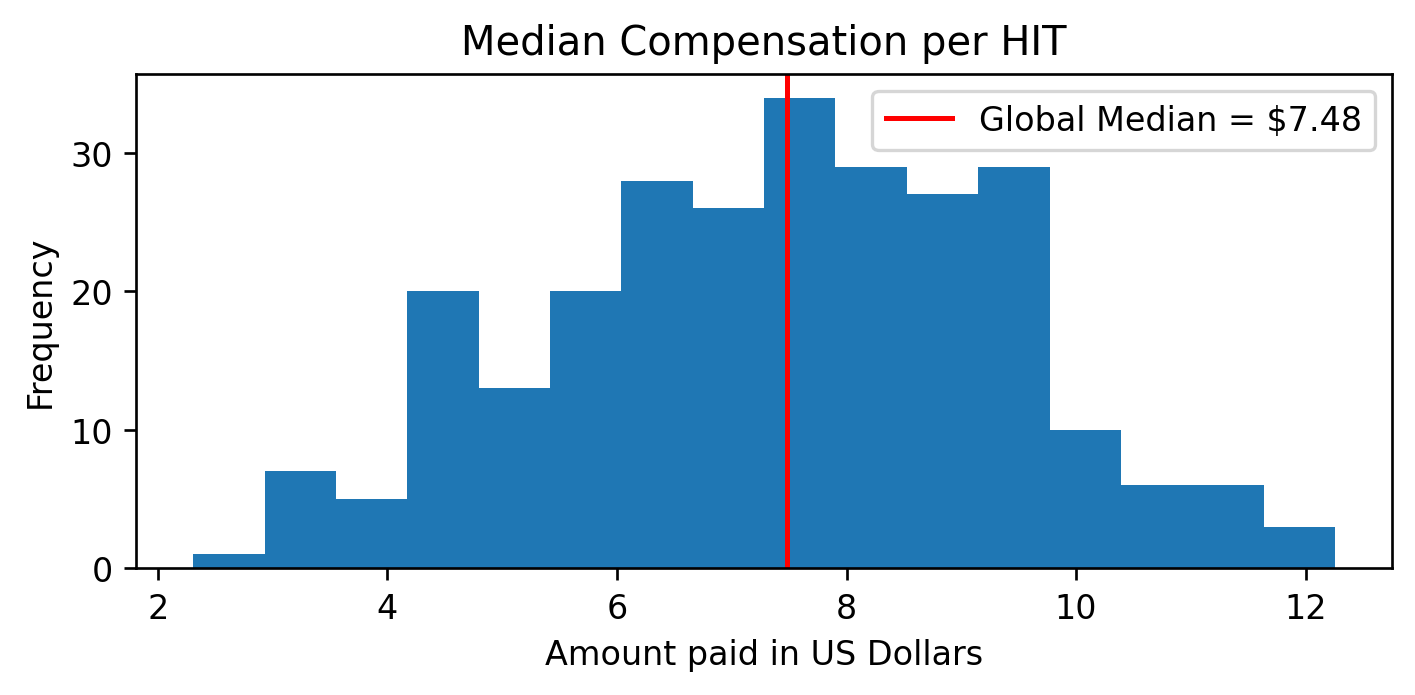

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3), dpi=240)
plt.title('Median Compensation per HIT')
plt.axvline(global_median, color='r')
median_task_comp.plot.hist(bins=16)
plt.legend([f'Global Median = ${global_median:.2f}'])
plt.xlabel('Amount paid in US Dollars')
plt.tight_layout()
plt.savefig('../output/MTurkCompensationPerHIT.pdf')
plt.show()

In [14]:
(batch_df.Approve == 'x').sum()

1315

In [15]:
100 * (batch_df.Approve == 'x').sum() / len(batch_df)

97.33530717986676

In [16]:
batch_df[batch_df.Approve != 'x']

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Last7DaysApprovalRate,Input.INSTANCE_DATA,Answer.currentAnnotation,Answer.permutation,Approve,Reject,Reasons,EmotionScore,CategoryScore,ApprovalFraction
472,3LG268AV38NZOI6HS5RP9AOSD5ARE9,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:37 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (128/128),"[{""emotion"": ""Impatient"", ""text"": ""I hope so b...",,"0,4,2,6,9,1,8,3,7,5",,Not all instances were annotated. The HIT incl...,([Not all instances were annotated. The HIT in...,0.0,0.0,0.953125
545,3XBXDSS8880XRK2LIQKLBN00NJWXLY,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:54 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,100% (128/128),"[{""emotion"": ""Optimistic"", ""text"": ""Magic happ...",,"2,0,6,3,4,1,7,5,8,9",,Not all instances were annotated. The HIT incl...,([Not all instances were annotated. The HIT in...,0.0,0.0,0.953125
956,3ZVPAMTJWNKX8W28Y0HD9D94QLPRGQ,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:43 PDT 2021,6,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,64% (18/28),"[{""emotion"": ""Spacey"", ""text"": ""You search you...","Creative,Lazy,Excited,Sad,Happy,Excited,Sad,Sa...","0,9,4,6,1,2,3,7,5,8",,Your annotation quality is not sufficient. You...,([Your annotation quality is not sufficient. Y...,0.0,0.1,0.571429
958,3DFYDSXB2WHZFQKQA0XLB1O4PCAJUQ,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:34 PDT 2021,6,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,64% (18/28),"[{""emotion"": ""Dreamy"", ""text"": ""I took an 11 m...","Happy,Impatient,Sleepy,Content,Insecure,Angry,...","5,3,8,4,0,7,9,6,1,2",,Your annotation quality is not sufficient. You...,([Your annotation quality is not sufficient. Y...,0.0,0.0,0.571429
959,31GN6YMHLP956XSLSUL0LQ0O6BYWSI,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:35 PDT 2021,6,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,64% (18/28),"[{""emotion"": ""Exhausted"", ""text"": ""Literally e...","Relieved,Meh,Meh,Meh,Nostalgic,Meh,Nostalgic,O...","1,2,6,9,5,7,8,4,0,3",,Your annotation speed is suspicious. The HIT i...,([Your annotation speed is suspicious. The HIT...,0.0,0.0,0.571429
961,3MD8CKRQZZ47ZYS9662G6Q1KID6RJU,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:44 PDT 2021,6,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,64% (18/28),"[{""emotion"": ""Imaginative"", ""text"": ""So my tea...","Lazy,Meh,Meh,Happy,Upset,Impatient,Happy,Impat...","6,8,7,9,3,2,4,0,5,1",,Your annotation speed is suspicious. The HIT i...,([Your annotation speed is suspicious. The HIT...,0.0,0.0,0.571429
962,3XBYQ44Z6PL6LX50HUQQVVWA8UCWT7,3M55KGTKUZ6FAU1RJZG4F95E03P4P0,Internal emotion detection inferred from socia...,What emotion did the person writing this text ...,"emotion detection, text",$0.32,Mon Mar 29 12:30:35 PDT 2021,5,BatchId:4386904;OriginalHitTemplateId:928390866;,900,...,64% (18/28),"[{""emotion"": ""Surprised"", ""text"": ""This is an ...","Nostalgic,Happy,Safe,Motivated,Sad,Nostalgic,P...","2,1,5,7,8,3,0,6,4,9",,Your annotation quality is not sufficient. You...,([Your annotation quality is not suf

In [17]:
batch_df[(batch_df.Approve == 'x')].groupby('HITId').size().median()

5.0

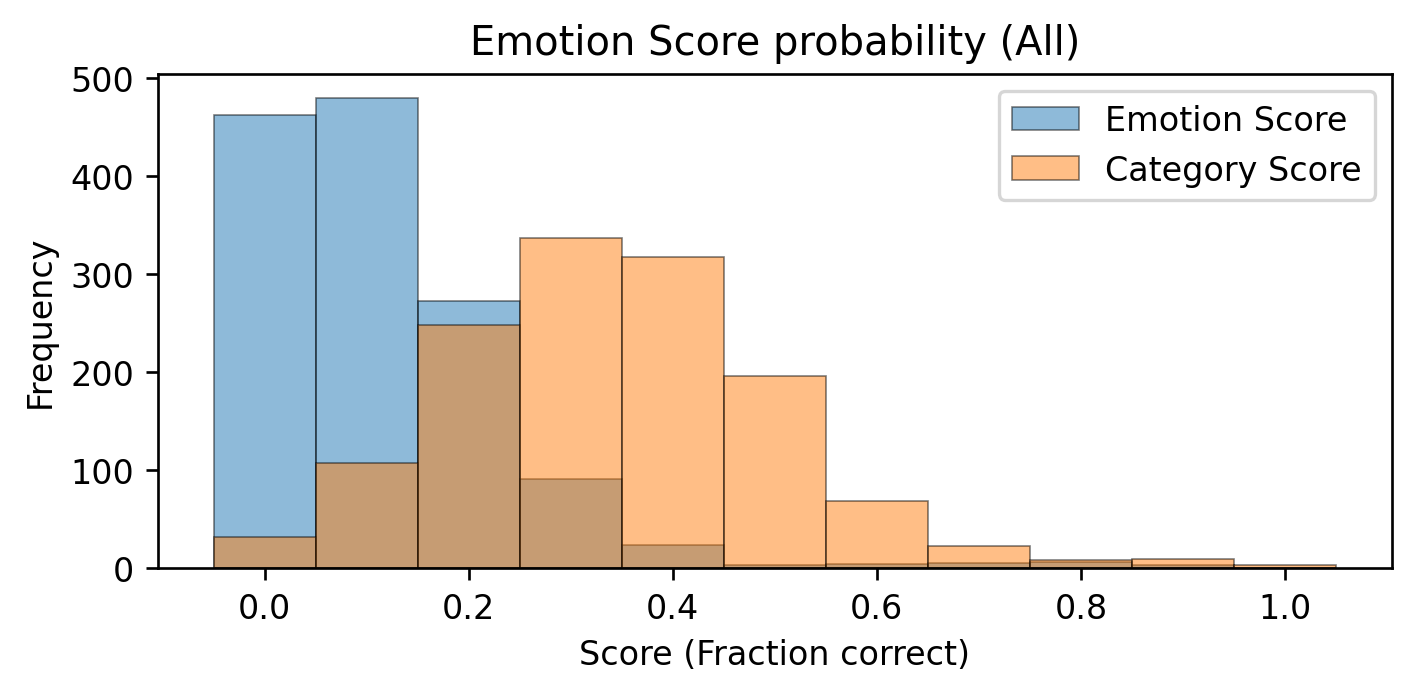

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3), dpi=240)
batch_df.EmotionScore.plot.hist(bins=11, range=(-0.05, 1.05), alpha=0.5, linewidth=0.5, edgecolor='k')
batch_df.CategoryScore.plot.hist(bins=11, range=(-0.05, 1.05), alpha=0.5, linewidth=0.5, edgecolor='k')
plt.title('Emotion Score probability (All)')
plt.xlabel('Score (Fraction correct)')
plt.legend(['Emotion Score', 'Category Score'])
plt.tight_layout()
plt.show()

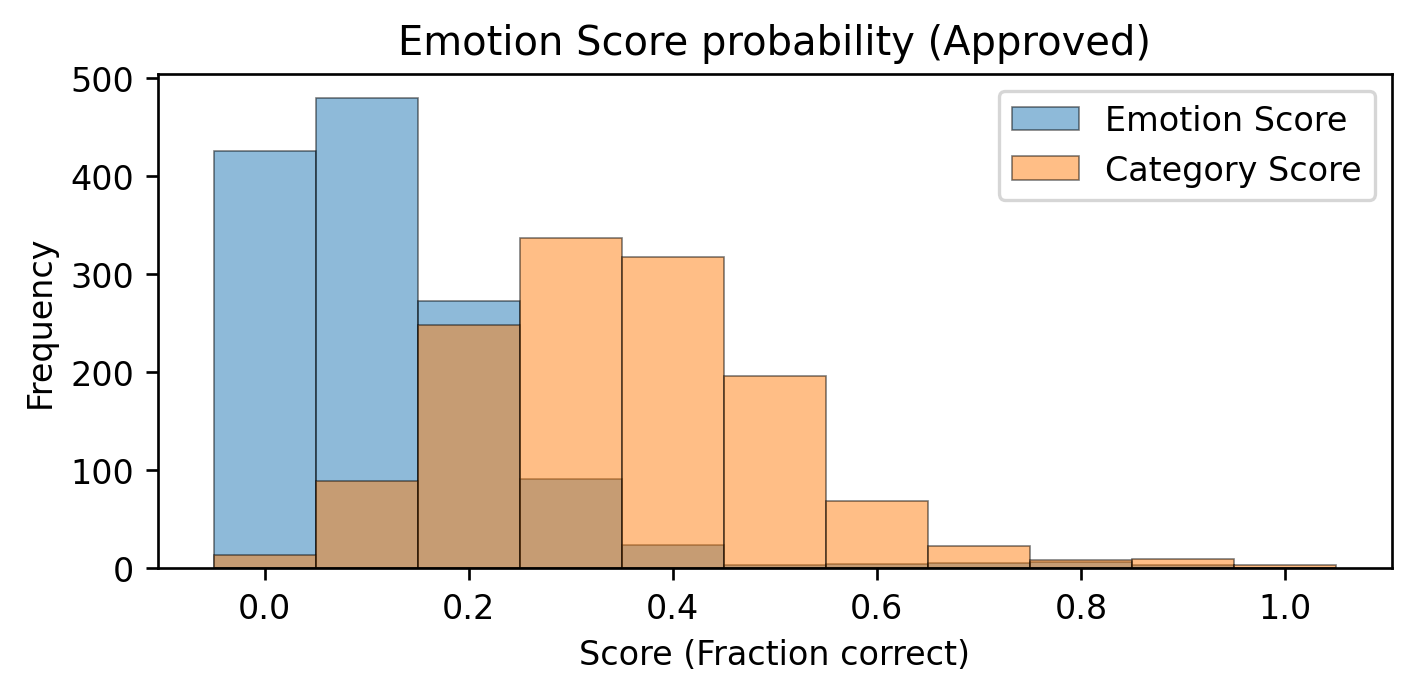

In [19]:
import matplotlib.pyplot as plt

approved_df = batch_df[batch_df.Approve == 'x']

plt.figure(figsize=(6, 3), dpi=240)
approved_df.EmotionScore.plot.hist(bins=11, range=(-0.05, 1.05), alpha=0.5, linewidth=0.5, edgecolor='k')
approved_df.CategoryScore.plot.hist(bins=11, range=(-0.05, 1.05), alpha=0.5, linewidth=0.5, edgecolor='k')
plt.title('Emotion Score probability (Approved)')
plt.xlabel('Score (Fraction correct)')
plt.legend(['Emotion Score', 'Category Score'])
plt.tight_layout()
plt.savefig('../output/MTurkApprovedScores.pdf')
plt.show()

In [20]:
import json
from pprint import pprint
from collections import Counter

approved_df = batch_df[batch_df.Approve == 'x']
emotions = [y['emotion'] for x in approved_df['Input.INSTANCE_DATA'] for y in json.loads(x)]
annotations = [y for x in approved_df['Answer.currentAnnotation'].tolist() for y in x.split(',')]

emo_ctr = Counter(emotions)
pprint(emo_ctr.most_common())
print(len(emo_ctr))

anno_ctr = Counter(annotations)
pprint(anno_ctr.most_common())
print(len(anno_ctr))

[('Relaxed', 150),
 ('Interested', 150),
 ('Hurt', 150),
 ('Lazy', 150),
 ('Inspired', 150),
 ('Worried', 150),
 ('Shy', 150),
 ('Disappointed', 150),
 ('Frustrated', 150),
 ('Adventurous', 150),
 ('Affectionate', 150),
 ('Meh', 150),
 ('Amused', 150),
 ('Ashamed', 150),
 ('Motivated', 150),
 ('Heartbroken', 150),
 ('Irritated', 150),
 ('Musical', 150),
 ('Lost', 150),
 ('Bitter', 150),
 ('Poetic', 150),
 ('Safe', 150),
 ('Astonished', 150),
 ('Nostalgic', 150),
 ('Conflicted', 150),
 ('Disgusted', 150),
 ('Loving', 150),
 ('Caring', 150),
 ('Stressed', 150),
 ('Adoring', 150),
 ('Thoughtful', 150),
 ('Content', 150),
 ('Excited', 150),
 ('Infatuated', 150),
 ('Creative', 150),
 ('Numb', 150),
 ('Shocked', 150),
 ('Hopeful', 150),
 ('Angry', 150),
 ('Exhausted', 150),
 ('Anxious', 150),
 ('Curious', 150),
 ('Confident', 150),
 ('Miserable', 150),
 ('Sorry', 150),
 ('Thankful', 150),
 ('Uncomfortable', 149),
 ('Jealous', 149),
 ('Upset', 149),
 ('Guilty', 149),
 ('Amazed', 149),
 ('Spac